In [22]:
%matplotlib notebook
import numpy as np
import io
import sys
import matplotlib.pyplot as plt
import time
from scipy.special import expit

# description of the network
## 1. Structure
Three hidden layer, output is a 10-by-1 vector.
$$x\overset{w^{(1})}{\Longrightarrow}h^{(1)}\overset{w^{(2)}}{\Longrightarrow}h^{(2)}\overset{w^{(3)}}{\Longrightarrow}h^{(3)}\overset{v}{\Longrightarrow}d$$
The activation function is the logistic function,
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$
$$\frac{d\sigma(z)}{dz} = \sigma(z) (1 - \sigma(z))$$
## 2. Equation
loss function is $f(w) = \frac{1}{2}(\hat{d} - d)^2$, where $\hat{d}$ is the prediction, $d$ is th eactual label.
### part 1
$$\frac{\partial f}{\partial v_{ij}} =  (\hat{d_i}-d_i)\hat{d_i}(1-\hat{d_i})h^{(3)}_{j}$$
with $\tilde{d_i} = (\hat{d_i}-d_i)\hat{d_i}(1-\hat{d_i}), \partial\tilde{v_{ij}} = \frac{\partial f}{\partial v_{ij}}$,
$$\partial\tilde{v} = \tilde{d} {h^{(3)}}^T$$
### part 2
$$\frac{\partial f}{\partial w^{(3)}_{ab}} =  \sum_i (\hat{d_i}-d_i)\hat{d_i}(1-\hat{d_i}) v_{ia} h^{(3)}_a(1-h^{(3)}_a)h^{(2)}_b$$
with $\tilde{h}^{(3)}_a = h^{(3)}_a(1-h^{(3)}_a), \partial\tilde{w}^{(3)}_{ab} = \frac{\partial f}{\partial w^{(3)}_{ab}}$,
$$\partial\tilde{w}^{(3)} = (\tilde{d}^T v)^T \circ \tilde{h}^{(3)} {h^{(2)}}^T$$
where $\circ$ represents element-wise multiplication. For $B_{n\times m} = A_{n \times m} \circ x_{1 \times m}$ where dimensions do not match, $B_{ij} = A_{ij}x_j$.
### part 3
$$\frac{\partial f}{\partial w^{(2)}_{cd}} =  \sum_i (\hat{d_i}-d_i)\hat{d_i}(1-\hat{d_i}) \sum_a v_{ia} h^{(3)}_a(1-h^{(3)}_a) w^{(3)}_{ac} h^{(2)}_c(1-h^{(2)}_c) h^{(1)}_d$$
with $\tilde{h}^{(2)}_c = h^{(2)}_a(1-h^{(2)}_c), \partial\tilde{w}^{(2)}_{cd} = \frac{\partial f}{\partial w^{(2)}_{cd}}$,
$$\partial\tilde{w}^{(2)} = (\tilde{d}^T v \circ {\tilde{h}^{(3)}}^T w^{(3)})^T \circ \tilde{h}^{(2)} {h^{(1)}}^T$$
### part 4
$$\frac{\partial f}{\partial w^{(1)}_{ef}} =  \sum_i (\hat{d_i}-d_i)\hat{d_i}(1-\hat{d_i}) \sum_a v_{ia} h^{(3)}_a (1-h^{(3)}_a) \sum_c w^{(n)}_{ac} h^{(2)}_c (1-h^{(2)}_c) w^{(2)}_{ce} h^{(1)}_e(1-h^{(1)}_e) x_f$$
with $\tilde{h}^{(1)}_e = h^{(1)}_e(1-h^{(1)}_e), \partial\tilde{w}^{(1)}_{ef} = \frac{\partial f}{\partial w^{(1)}_{ef}}$,
$$\partial\tilde{w}^{(1)} = (\tilde{d}^T v \circ {\tilde{h}^{(3)}}^T w^{(3)} \circ {\tilde{h}^{(2)}}^T w^{(2)})^T \circ \tilde{h}^{(1)} x^T$$

In [32]:
# read in the training data
trainImages = io.open('train-images.idx3-ubyte', 'rb')
trainLabels = io.open('train-labels.idx1-ubyte', 'rb')

In [7]:
magic = int.from_bytes(trainImages.read(4), byteorder='big')
if magic != 2051:
    sys.exit('Wrong magic number for train-images.idx3-ubyte')
    
magic = int.from_bytes(trainLabels.read(4), byteorder='big')
if magic != 2049:
    sys.exit('Wrong magic number for train-labels.idx3-ubyte')

imageNum = int.from_bytes(trainImages.read(4), byteorder='big')
labelNum = int.from_bytes(trainLabels.read(4), byteorder='big')

num = min(imageNum, labelNum)

# dimensions of each image
rowNum = int.from_bytes(trainImages.read(4), byteorder='big')
colNum = int.from_bytes(trainImages.read(4), byteorder='big')

images = np.zeros(num*colNum*rowNum).reshape(num, colNum*rowNum)
for i in range(num):
    for j in range(colNum*rowNum):
        images[i, j] = int.from_bytes(trainImages.read(1), byteorder='big', signed=False)

labels = np.zeros(num)
for i in range(num):
    labels[i] = int.from_bytes(trainLabels.read(1), byteorder='big', signed=False)

trainImages.close()
trainLabels.close()

In [8]:
# read in the test data
testImages = io.open('t10k-images.idx3-ubyte', 'rb')
testLabels = io.open('t10k-labels.idx1-ubyte', 'rb')

In [9]:
magicT = int.from_bytes(testImages.read(4), byteorder='big')
if magicT != 2051:
    sys.exit('Wrong magic number for t10k-images.idx3-ubyte')
    
magicT = int.from_bytes(testLabels.read(4), byteorder='big')
if magicT != 2049:
    sys.exit('Wrong magic number for t10k-labels.idx3-ubyte')

imageNumT = int.from_bytes(testImages.read(4), byteorder='big')
labelNumT = int.from_bytes(testLabels.read(4), byteorder='big')

numT = min(imageNumT, labelNumT)

# dimensions of each image
rowNumT = int.from_bytes(testImages.read(4), byteorder='big')
colNumT = int.from_bytes(testImages.read(4), byteorder='big')

imagesT = np.zeros(numT*colNumT*rowNumT).reshape(numT, colNumT*rowNumT)
for i in range(numT):
    for j in range(colNumT*rowNumT):
        imagesT[i, j] = int.from_bytes(testImages.read(1), byteorder='big', signed=False)

labelsT = np.zeros(numT)
for i in range(numT):
    labelsT[i] = int.from_bytes(testLabels.read(1), byteorder='big', signed=False)

testImages.close()
testLabels.close()

# training with one image per iteration

In [195]:
# define the parameter of the neural network
N1 = 150 # node count of the 1st hidden layer
N2 = 50 # node count of the 2ed hidden layer
N3 = 40 # node count of the 3rd hidden layer
D = 10 # dimension of ouput
alpha = 0.01 # step size for stochastic gradient descent

In [196]:
h1 = np.zeros((N1, 1))
h2 = np.zeros((N2, 1))
h3 = np.zeros((N3, 1))

w1 = np.random.normal(size=(N1, colNum*rowNum))
w2 = np.random.normal(size=(N2, N1))
w3 = np.random.normal(size=(N3, N2))
v = np.random.normal(size=(D, N3))

cnt = N1*colNum*rowNum + N2*N1 + N3*N2 + D*N3

wPartial1 = np.zeros((w1.shape))
wPartial2 = np.zeros((w2.shape))
wPartial3 = np.zeros((w3.shape))
vPartial = np.zeros((v.shape))

i = 0
ITER = 800000
errorRate = np.zeros(int(ITER/100))
right = 0
count = 0

while i < ITER:
    
    j = np.random.randint(images.shape[0])
    x = images[j:j+1, :].T
    digit = labels[j]
    d = np.zeros((D, 1))
    d[digit.astype(int)] = 1
    
    h1 = w1@x
    h1 = expit(h1)
    h2 = w2@h1
    h2 = expit(h2)
    h3 = w3@h2
    h3 = expit(h3)
    dHat = v@h3
    dHat = expit(dHat)
    
    count = count + 1
    if np.argmax(dHat) == digit:
        right = right + 1
    
    if i%100 == 0:
        errorRate[i//100] = 1- right / count
    
    dTilde = (dHat - d) * dHat * (1 - dHat)
    
    hTilde1 = h1 * (1 - h1)
    hTilde2 = h2 * (1 - h2)
    hTilde3 = h3 * (1 - h3)
    
    vPartial = dTilde@h3.T
    wPartial3 = (dTilde.T@v).T*hTilde3@h2.T
    wPartial2 = (dTilde.T@v*hTilde3.T@w3).T*hTilde2@h1.T
    wPartial1 = (dTilde.T@v*hTilde3.T@w3*hTilde2.T@w2).T*hTilde1@x.T
    
    v = v - alpha*vPartial
    w1 = w1 - alpha*wPartial1
    w2 = w2 - alpha*wPartial2
    w3 = w3 - alpha*wPartial3
    
    i = i + 1
    
    if alpha*(np.linalg.norm(vPartial)\
    + np.linalg.norm(wPartial1)\
    + np.linalg.norm(wPartial2)\
    + np.linalg.norm(wPartial3)) < 10**(-7):
        break

# batch training

In [207]:
# define the parameter of the neural network
N1 = 150 # node count of the 1st hidden layer
N2 = 50 # node count of the 2ed hidden layer
N3 = 50 # node count of the 3rd hidden layer
D = 10 # dimension of ouput
alpha = 0.01 # step size for stochastic gradient descent

In [210]:
h1 = np.zeros((N1, 1))
h2 = np.zeros((N2, 1))
h3 = np.zeros((N3, 1))

w1 = np.random.normal(size=(N1, colNum*rowNum))
w2 = np.random.normal(size=(N2, N1))
w3 = np.random.normal(size=(N3, N2))
v = np.random.normal(size=(D, N3))

cnt = N1*colNum*rowNum + N2*N1 + N3*N2 + D*N3

wPartial1 = np.zeros((w1.shape))
wPartial2 = np.zeros((w2.shape))
wPartial3 = np.zeros((w3.shape))
vPartial = np.zeros((v.shape))

i = 0
ITER = 10000
errorRate = np.zeros(int(ITER/10))
right = 0
count = 0

while i < ITER:
    
    wPartial1 = np.zeros((w1.shape))
    wPartial2 = np.zeros((w2.shape))
    wPartial3 = np.zeros((w3.shape))
    vPartial = np.zeros((v.shape))
    
    for k in range(256):
        j = np.random.randint(images.shape[0])
        x = images[j:j+1, :].T
        digit = labels[j]
        d = np.zeros((D, 1))
        d[digit.astype(int)] = 1

        h1 = w1@x
        h1 = expit(h1)
        h2 = w2@h1
        h2 = expit(h2)
        h3 = w3@h2
        h3 = expit(h3)
        dHat = v@h3
        dHat = expit(dHat)

        count = count + 1
        if np.argmax(dHat) == digit:
            right = right + 1

        dTilde = (dHat - d) * dHat * (1 - dHat)

        hTilde1 = h1 * (1 - h1)
        hTilde2 = h2 * (1 - h2)
        hTilde3 = h3 * (1 - h3)

        vPartial = vPartial + dTilde@h3.T
        wPartial3 = wPartial3 + (dTilde.T@v).T*hTilde3@h2.T
        wPartial2 = wPartial2 + (dTilde.T@v*hTilde3.T@w3).T*hTilde2@h1.T
        wPartial1 = wPartial1 + (dTilde.T@v*hTilde3.T@w3*hTilde2.T@w2).T*hTilde1@x.T
    
    if i%10 == 0:
        errorRate[i//10] = 1- right / count

    v = v - alpha*vPartial
    w1 = w1 - alpha*wPartial1
    w2 = w2 - alpha*wPartial2
    w3 = w3 - alpha*wPartial3
    
    i = i + 1
    
    if alpha*(np.linalg.norm(vPartial)\
    + np.linalg.norm(wPartial1)\
    + np.linalg.norm(wPartial2)\
    + np.linalg.norm(wPartial3)) < 10**(-7):
        break

In [211]:
# test
labelsHat = np.zeros(labelsT.shape[0])
for j in range(labelsT.shape[0]):
    x = imagesT[j:j+1, :].T
    digit = labelsT[j].astype(int)
    
    h1 = w1@x
    h1 = expit(h1)
    h2 = w2@h1
    h2 = expit(h2)
    h3 = w3@h2
    h3 = expit(h3)
    dHat = v@h3
    dHat = expit(dHat)
    
    labelsHat[j] = np.argmax(dHat.flatten())

errorRate = 1- np.sum(labelsHat == labelsT) / labelsT.shape[0]
print('error rate:', errorRate)

error rate: 0.12370000000000003


## one image per iteration
### notes
Intially, all the weights are initialized to zero. But the training does not work. The weights of the first layer $w^{(1)}$ does not change at all after 1 million iterations.

Then the weights are initialized with random Gauss distribution.
### change number of iterations
| Iterations($10^4$) | Nodes of layer 1 | Nodes of layer 2 | Nodes of layer 3 | error rate |
|--------------------|------------------|------------------|------------------|------------|
| 100                | 50 | 50 | 50 | 0.199|
| 80                | 50 | 50 | 50 | 0.197|
| 60                | 50 | 50 | 50 | 0.213|
| 40                | 50 | 50 | 50 | 0.234|
| 20                | 50 | 50 | 50 | 0.39|
| 6                | 50 | 50 | 50 | 0.542|
### change the number of nodes of the 1st layer
| Iterations($10^4$) | Nodes of layer 1 | Nodes of layer 2 | Nodes of layer 3 | error rate |
|--------------------|------------------|------------------|------------------|------------|
| 80                | 50 | 50 | 50 | 0.197|
| 80                | 60 | 50 | 50 | 0.1915|
| 80                | 70 | 50 | 50 | 0.188|
| 80                | 80 | 50 | 50 | 0.171|
| 80                | 90 | 50 | 50 | 0.187|
| 80                |100 | 50 | 50 | 0.170|
| 80                |120 | 50 | 50 | 0.176|
| 80                |150 | 50 | 50 | 0.155|
| 80                |200 | 50 | 50 | 0.1553|
| 80                |300 | 50 | 50 | 0.140|
When the Nodes of layer 1 are increased into 300, the training time can as long as tens of minutes.
## Batch training
| Iterations($10^4$) | Nodes of layer 1 | Nodes of layer 2 | Nodes of Layer 3 | Batch size | Error Rate |
|--------------------|------------------|------------------|------------------|------------|------------|
| 1 | 150 | 50 | 50 | 80 | 0.1519 |
| 1 | 150 | 50 | 50 | 128 | 0.137 |
| 1 | 150 | 50 | 50 | 256 | 0.124 |

In [176]:
pair = np.hstack((labelsT.reshape(labelsT.shape[0],1),\
                                      labelsHat.reshape(labelsHat.shape[0],1)))

<IPython.core.display.Javascript object>


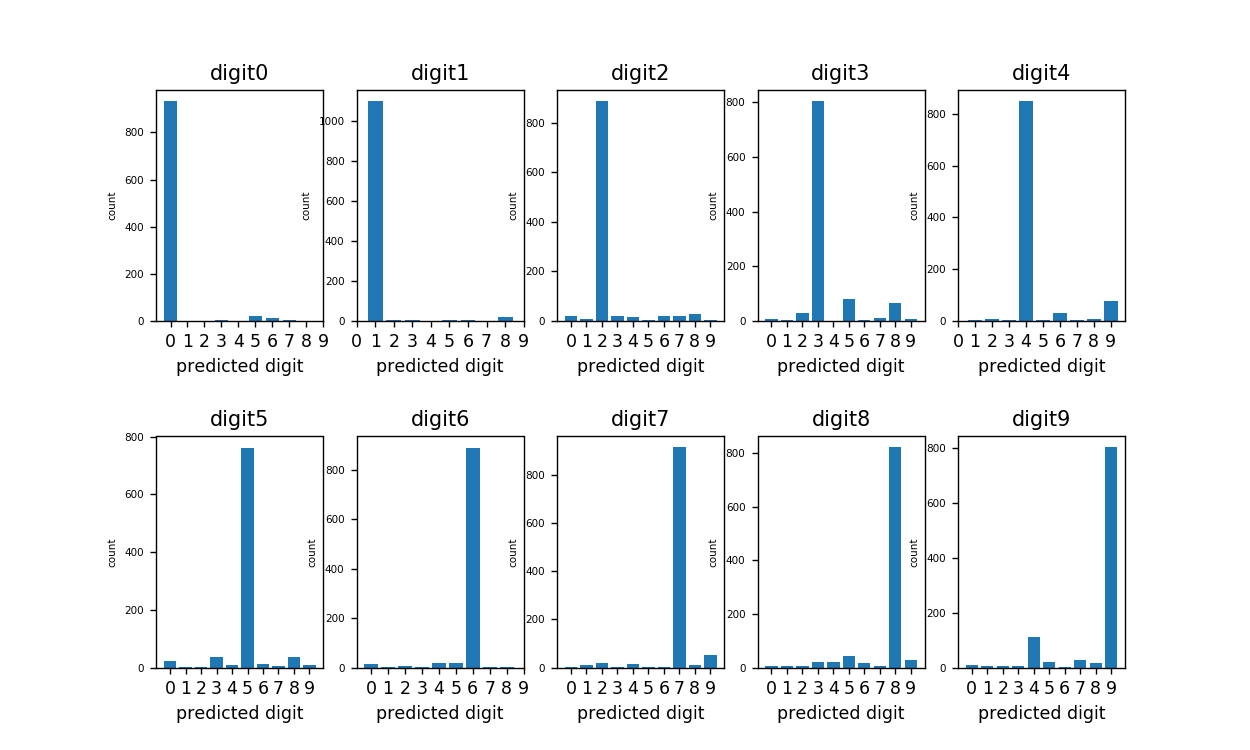

In [212]:
unique, counts = np.unique(np.hstack((labelsT.reshape(labelsT.shape[0],1),\
                                      labelsHat.reshape(labelsHat.shape[0],1))), axis=0, return_counts=True)

fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    actual = unique[:,0]
    prediction = unique[:,1]
    ax.bar(prediction[actual==i], counts[actual==i])
    plt.xticks(np.arange(0,10))
    plt.yticks(fontsize=6)
    ax.set_xlabel('predicted digit')
    ax.set_ylabel('count', fontsize=6)
    ax.title.set_text('digit'+ str(i))
plt.show()

In [31]:
print(images.shape[0])
print(np.random.randint(10))
a = np.zeros(10)
a[labels[5].astype(int)] = 10
print(a)
a= labels[10]
print(a)
print(np.arange(0,9).reshape(3,3))
print(np.arange(0,9).reshape(3,3)*np.arange(0,3).reshape(1,3))
print(expit(np.arange(9).reshape(3,3)))

60000
1
[ 0.  0. 10.  0.  0.  0.  0.  0.  0.  0.]
3.0
[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[ 0  1  4]
 [ 0  4 10]
 [ 0  7 16]]
[[0.5        0.73105858 0.88079708]
 [0.95257413 0.98201379 0.99330715]
 [0.99752738 0.99908895 0.99966465]]
